Data Understanding¶

        The dataset pertains to direct marketing campaigns conducted by a Portuguese banking institution. These campaigns involved phone calls, often requiring multiple contacts with the same client to determine if they would subscribe to a bank term deposit (indicated as 'yes') or not (indicated as 'no').

Objective:

        The goal is to classify whether a client will subscribe to a term deposit (variable y) based on various features.

Variable Definitions:

        age : Age of bank customers, ranging from 18 to 95.
        job : Type of job (e.g., housemaid, blue-collar, management, retired).
        marital : Marital status (e.g., married, single, divorced).
        education: Education level (e.g., high school, illiterate, university degree).
        default : Indicates if the customer has credit in default.
        balance : Average yearly balance of customers.
        housing : Indicates whether the customer has a housing loan.
        loan : Indicates whether the customer has a personal loan.
        contact : Type of communication used to contact the customer (e.g., cellular, telephone).
        day : Day of the week when the last contact was made(Date).
        month : Month of the last contact..
        duration : Duration of the last call in seconds.
        campaign : Number of contacts made during this campaign for this client (numeric, includes the last contact).
        pdays : Number of days since the client was last contacted in a previous campaign.
        previous : Number of contacts made before this campaign for this client.
        poutcome : Outcome of the previous marketing campaign
        y : Indicates whether the client subscribed to a term deposit (yes/no).f the week

## Create Functions for model training and evaluation

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier


warnings.filterwarnings("ignore")
%matplotlib inline

In [32]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [33]:
train_df = pd.read_csv(r"C:\Users\JOY\Downloads\archive\Train.csv")
test_df = pd.read_csv(r"C:\Users\JOY\Downloads\archive\Test.csv")

df = pd.concat([train_df,test_df],ignore_index = True)

#df.to_csv("bank.csv",index = False)

df.head()
df.shape

(49732, 17)

In [34]:

df.drop_duplicates(inplace=True)
df.shape

(45211, 17)

In [35]:
# Check unique values of target varaible
df['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [36]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 7 numerical features : ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

We have 10 categorical features : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


# Converting unknown values and -1 values to NaN values

In [37]:
# Converting the values with -1 value to Null
df.pdays[df.pdays == -1] = np.nan

# Assigning 'NaN' to 'unknown' values to col
col = ['job', 'education', 'contact', 'poutcome']

for column in col:
    df[column].replace('unknown', np.nan, inplace=True)

# Viewing percentage of missing values
print("Percentage of Missing Values")
round((df.isnull().sum()[df.isnull().sum()>0]*100)/df.shape[0],2)

Percentage of Missing Values


job           0.64
education     4.11
contact      28.80
pdays        81.74
poutcome     81.75
dtype: float64

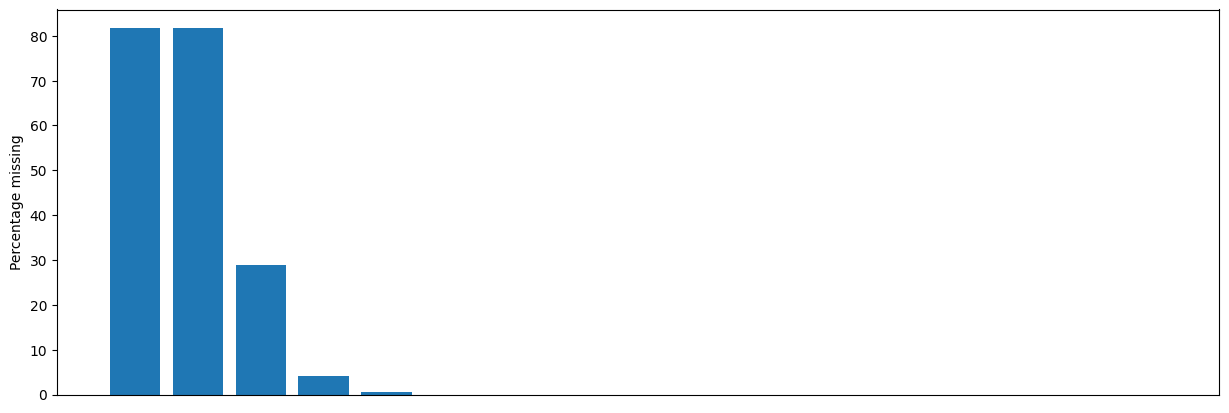

In [38]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [39]:
## Dropping columns which has more than 70% of missing values
dropcols = missing[missing[0]>70]
dropcols

,0
poutcome,81.747805
pdays,81.736745


In [40]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [41]:
# Check shape of the dataset after dropping columns
df.shape

(45211, 15)

### Check the total percentage of missing values of full dataset after dropping columns with more than 70% of missing values

In [42]:
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 2.236181460264095%


## Visualization of unique values in Target variable

Positive: 5289, Negative: 39922


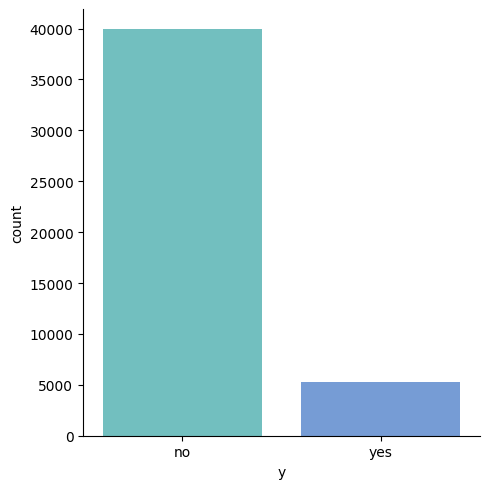

In [43]:
pos = df[df['y']=='yes'].shape[0]
neg = df[df['y']=='no'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="y", kind="count", palette="winter_r", alpha=.6)
plt.show()

**Report**
- The target classes are highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. 
- Hence we should handle imbalanced data with certain methods.

**How to handle Imbalance Data ?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

## Create Functions for model training and evaluation

In [44]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [45]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list)), columns=['Model Name'])
        
    return report

### Plot  distribution of all Independent Numerical variables

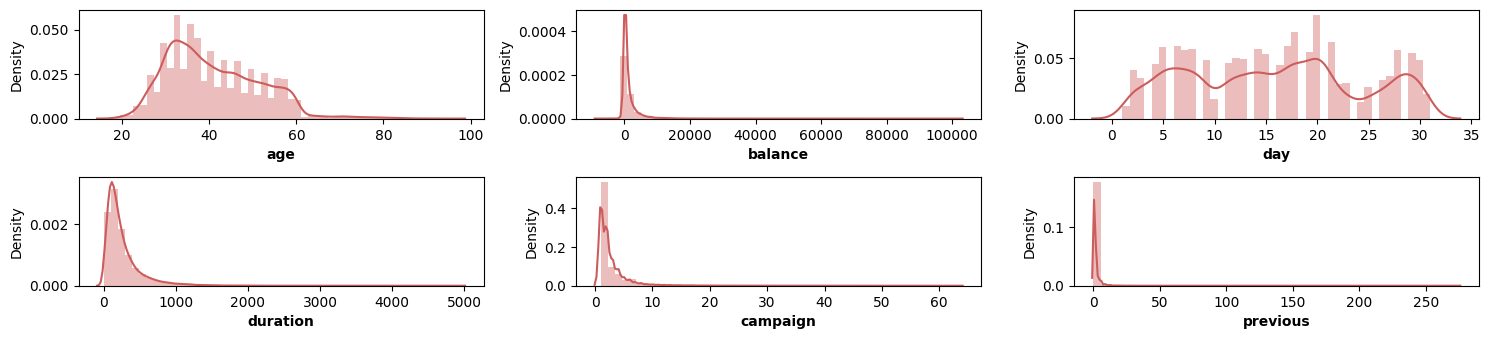

In [46]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

**Report**
- As per the above plot most of the features are not normally distributed.
- Transformation of data is not of prime importance since it is a classification problem.
- Interpreting each and every column is not necessary as this is sensor data.

# Evaluate Model on Different experiments

In [47]:
# Splitting X and y for all Experiments
X= df.drop('y', axis=1)
y = df['y']

- **Manually Encoding Target Variable**

In [48]:
y= y.replace({'yes': 1, 'no': 0})

In [49]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,3
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,0


### Experiment: 2 =  Imputing with Strategy Mode

- SimpleImputer is a class in the `sklearn.impute` module that can be used to replace missing values in a dataset, using a variety of input strategies.
- Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

In [50]:
mode_job = df['job'].mode()[0]
mode_contact = df['contact'].mode()[0]
mode_education = df['education'].mode()[0]

In [51]:
X["job"]=X["job"].fillna(mode_job)
X["contact"]=X["job"].fillna(mode_contact)
X["education"]=X["job"].fillna(mode_education)

In [52]:
transform = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson')),
    
    ])

ohe_columns = ['job','marital','education']
ord_columns = [ 'default', 'housing', 'loan', 'contact', 'month']
impute_cols = ['job','education','contact']
transform_cols = ['age','balance','duration','campaign','previous']
numerical_features = list(X.select_dtypes(exclude="object").columns)
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()
robust = RobustScaler()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, ohe_columns),
        ("Ordinal_Encoder", ordinal_encoder, ord_columns),
        ("Transformer", transform, transform_cols),
        ("RobustScaler", robust, numerical_features)
    ]
)




X_transformed = preprocessor.fit_transform(X)


In [53]:
X_transformed

array([[ 0.        ,  0.        ,  0.        , ...,  0.375     ,
        -0.5       ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.13425926,
        -0.5       ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ..., -0.48148148,
        -0.5       ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  4.38425926,
         1.5       ,  3.        ],
       [ 0.        ,  1.        ,  0.        , ...,  1.51851852,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.83796296,
         0.        , 11.        ]])

## Handling Imbalanced data

 **SMOTE+TOMEK** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
 
 - This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class
 
 - To add new data of minority class
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.
 
 - To remove the tomek links of the majority class
 1. Choose random data from the majority class.
 2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
 
 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [54]:

from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_transformed, y)

In [55]:
X_arr= np.c_[X_res, np.array(y_res)]


In [56]:
x_np, y_np = (
                X_arr[:, :-1],
                X_arr[:, -1],
                
            )

In [57]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X_np,y_np, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.2, random_state=42)
    
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list)), columns=['Model Name'])
        
    return report

### Experiment: 1 =Robust Scaler

    **Why Robust scaler and not Standard scaler?**
- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

**Why Robust Scaler and not Minmax?** 
- because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [58]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [59]:
model = evaluate_models(x_np,y_np,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9707
- F1 score: 0.9738
- Precision: 0.9686
- Recall: 0.9790
- Roc Auc Score: 0.9697


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9436
- F1 score: 0.9493
- Precision: 0.9473
- Recall: 0.9513
- Roc Auc Score: 0.9427


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9460
- F1 score: 0.9512
- Precision: 0.9482
- Recall: 0.9541
- Roc Auc Score: 0.9451
----------------------------------
Model performance for Test set
- Accuracy: 0.9436
- F1 score: 0.9493
- Precision: 0.9479
- Recall: 0.9507
- Roc Auc Score: 0.9427


Logistic Regression
Model performance for Training 

In [60]:
"""
Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9390
- F1 score: 0.9403
- Precision: 0.9218
- Recall: 0.9596
- Roc Auc Score: 0.9390
===================================


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9070
- F1 score: 0.9081
- Precision: 0.8983
- Recall: 0.9180
- Roc Auc Score: 0.9070
===================================


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9090
- F1 score: 0.9106
- Precision: 0.8950
- Recall: 0.9267
- Roc Auc Score: 0.9090
----------------------------------
Model performance for Test set
- Accuracy: 0.9062
- F1 score: 0.9081
- Precision: 0.8906
- Recall: 0.9263
- Roc Auc Score: 0.9062
===================================


Logistic Regression
Model performance for Training set
- Accuracy: 0.8147
- F1 score: 0.8182
- Precision: 0.8030
- Recall: 0.8339
- Roc Auc Score: 0.8147
----------------------------------
Model performance for Test set
- Accuracy: 0.8138
- F1 score: 0.8176
- Precision: 0.8016
- Recall: 0.8342
- Roc Auc Score: 0.8138
===================================


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9301
- F1 score: 0.9345
- Precision: 0.8791
- Recall: 0.9975
- Roc Auc Score: 0.9301
----------------------------------
Model performance for Test set
- Accuracy: 0.9051
- F1 score: 0.9128
- Precision: 0.8447
- Recall: 0.9928
- Roc Auc Score: 0.9051
===================================


XGBClassifier
Model performance for Training set
- Accuracy: 0.9637
- F1 score: 0.9635
- Precision: 0.9687
- Recall: 0.9584
- Roc Auc Score: 0.9637
----------------------------------
Model performance for Test set
- Accuracy: 0.9424
- F1 score: 0.9423
- Precision: 0.9449
- Recall: 0.9398
- Roc Auc Score: 0.9424
===================================


CatBoosting Classifier
Model performance for Training set
- Accuracy: 0.9648
- F1 score: 0.9644
- Precision: 0.9745
- Recall: 0.9544
- Roc Auc Score: 0.9648
----------------------------------
Model performance for Test set
- Accuracy: 0.9457
- F1 score: 0.9454
- Precision: 0.9517
- Recall: 0.9391
- Roc Auc Score: 0.9457
===================================


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.8811
- F1 score: 0.8815
- Precision: 0.8783
- Recall: 0.8847
- Roc Auc Score: 0.8811
----------------------------------
Model performance for Test set
- Accuracy: 0.8807
- F1 score: 0.8813
- Precision: 0.8772
- Recall: 0.8855
- Roc Auc Score: 0.8807"""

'\nRandom Forest\nModel performance for Training set\n- Accuracy: 1.0000\n- F1 score: 1.0000\n- Precision: 1.0000\n- Recall: 1.0000\n- Roc Auc Score: 1.0000\n----------------------------------\nModel performance for Test set\n- Accuracy: 0.9390\n- F1 score: 0.9403\n- Precision: 0.9218\n- Recall: 0.9596\n- Roc Auc Score: 0.9390\n===================================\n\n\nDecision Tree\nModel performance for Training set\n- Accuracy: 1.0000\n- F1 score: 1.0000\n- Precision: 1.0000\n- Recall: 1.0000\n- Roc Auc Score: 1.0000\n----------------------------------\nModel performance for Test set\n- Accuracy: 0.9070\n- F1 score: 0.9081\n- Precision: 0.8983\n- Recall: 0.9180\n- Roc Auc Score: 0.9070\n===================================\n\n\nGradient Boosting\nModel performance for Training set\n- Accuracy: 0.9090\n- F1 score: 0.9106\n- Precision: 0.8950\n- Recall: 0.9267\n- Roc Auc Score: 0.9090\n----------------------------------\nModel performance for Test set\n- Accuracy: 0.9062\n- F1 score: 0.